# Import

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
numerical = ['num_likes', 'num_comments', 'num_sent', 'sent_avg_length', 'num_words', 
             'num_unique_words', 'unique_words_percent', 'age', 'num_cats',
             'words_exist_per_cent',
             'shortlisted',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

categories = [   'cat_Age', 'cat_Happy', 'cat_Thriller', 
                 'cat_Friendship', 'cat_East', 'cat_Inspirational', 
                 'cat_Christian', 'cat_Bedtime', 'cat_Drama', 'cat_Horror', 
                 'cat_Lesbian', 'cat_High', 'cat_Science', 'cat_American', 
                 'cat_Speculative', 'cat_Funny', 'cat_Adventure', 
                 'cat_Nonfiction', 'cat_African', 'cat_Christmas', 
                 'cat_Teens', 'cat_Fantasy', 'cat_Holiday', 'cat_Western', 
                 'cat_Young', 'cat_Coming', 'cat_Suspense', 'cat_Romance', 
                 'cat_Urban', 'cat_Latinx', 'cat_Desi', 'cat_Asian', 
                 'cat_Black', 'cat_Sad', 'cat_Kids', 'cat_People', 'cat_Color', 
                 'cat_Fiction', 'cat_Contemporary', 'cat_Mystery', 'cat_Adult', 
                 'cat_Transgender', 'cat_Historical', 'cat_Middle', 'cat_Gay', 
                 'cat_Indigenous', 'cat_Crime', 'num_cats', 'cat_School', 
                 'cat_Creative']

In [15]:
feats_to_keep = numerical + txt_features + categories

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv", 
#                  usecols=feats_to_keep)
df = pd.read_csv("story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [18]:
target = 'num_likes'

# General features

## Preprocessing

In [19]:
numerical.remove('num_likes')
numerical.remove('num_comments')
numerical.remove('shortlisted')

In [20]:
X_gen = df[numerical+categories]

In [21]:
y = df[target].copy()

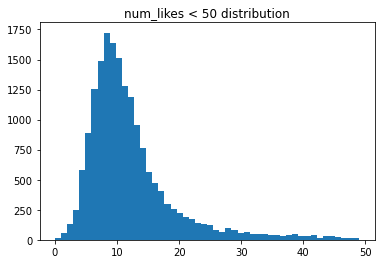

In [22]:
# TODO: to add this graph in the Medium article
df[df[target]<50][target].hist(bins=50, grid=False)
plt.title('num_likes < 50 distribution')
plt.show()

In [23]:
# turn y into labels 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)
threshold

13.0

In [24]:
print(f'Our threshold corresponds to \n{100*len(y[y <= threshold])/len(y):.2f}% of the stories being "bad", \n{100*len(y[y > threshold])/len(y):.2f}% of the stories being "good".')

Our threshold corresponds to 
71.03% of the stories being "bad", 
28.97% of the stories being "good".


In [25]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

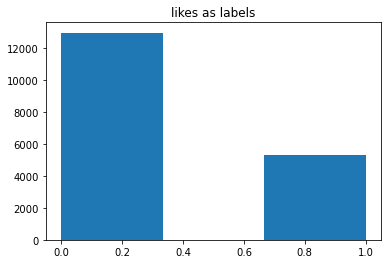

In [26]:
plt.hist(y, bins=3)
plt.title('likes as labels');

In [27]:
# log transform for relevant distributions
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
    X_gen[var_to_log] = X_gen[var_to_log].apply(np.log1p)

C:\Users\Batra\AppData\Local\Temp/ipykernel_11032/3419323431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_gen[var_to_log] = X_gen[var_to_log].apply(np.log1p)
C:\Users\Batra\AppData\Local\Temp/ipykernel_11032/3419323431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_gen[var_to_log] = X_gen[var_to_log].apply(np.log1p)
C:\Users\Batra\AppData\Local\Temp/ipykernel_11032/3419323431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [28]:
X_gen[['sent_avg_length', 'num_unique_words', 'emotion_love']].describe()

,sent_avg_length,num_unique_words,emotion_love
count,18248.000000,18248.000000,18248.000000
mean,2.945298,6.441081,0.026113
std,0.297524,0.289961,0.024489
min,1.648124,5.236442,0.000000
25%,2.764136,6.204558,0.009009
50%,2.920225,6.410175,0.020409
75%,3.089229,6.677083,0.037434
max,7.286192,7.318540,0.274437


In [29]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train_gen, X_test_gen, y_train, y_test = train_test_split(X_gen, y, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                   stratify=y)
X_train_gen.shape, X_test_gen.shape, y_train.shape, y_test.shape

((14598, 67), (3650, 67), (14598, 1), (3650, 1))

In [30]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_gen = pd.DataFrame(scaler.fit_transform(X_train_gen), columns=X_train_gen.columns)
X_test_gen = pd.DataFrame(scaler.transform(X_test_gen), columns=X_train_gen.columns)

X_train_gen.shape, X_test_gen.shape

((14598, 67), (3650, 67))

In [31]:
train_ind = X_train_gen.index
test_ind = X_test_gen.index

In [32]:
y_train = y_train.ravel()
y_test = y_test.ravel()

## Predictions

### Help functions

In [70]:
def display_conf_matr(y_test, y_pred, model, threshold='0.5'):
    conf_matr = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(conf_matr, cmap=['white'], annot=True, fmt='d', cbar=False, 
            linecolor='k', linewidth=2)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title(f'confusion matrix for {model}\nwhen threshold={threshold:.4f}')
    plt.show()
    print('\n')
    
    # extra metrics
    tn, fp, fn, tp = conf_matr.ravel()

    print(f'{tp*100/(tp+fn):.2f}% of the good stories have been correctly identified ~ recall')
    print(f'{fp*100/(fp+tn):.2f}% of the bad stories have been incorrectly identified as good ones ~ TNR')

In [47]:
def display_roc_curve(y_test,  y_probs, name_model):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
    plt.title(f"Receiver operating characteristic\nROC curve - {name_model}")
    plt.xlabel('rate of false positives\nFPR')
    plt.ylabel('rate of true positives\nTPR')
    plt.legend(loc='best')
    plt.show()

In [35]:
def display_feat_importance(coefs, cols):
    try:
        cols = [x for _, x in sorted(zip(coefs, cols))]
        plt.figure(figsize=(15,15))
        for col, coef in zip(cols, sorted(coefs)):
            plt.barh(col, coef)
    except AttributeError:
        print('No feature importance')
    plt.show()

In [40]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # classification report
    print('Classification report\nfor default threshold')
    print(classification_report(y_test, y_pred))
    print('\n')

    # confusion matrix
    display_conf_matr(y_test, y_pred, name_model)
    print('\n')

    # roc curve
    y_probs = model.predict_proba(X_test)[:,1]
    display_roc_curve(y_test,  y_probs, name_model)
    print('\n')

    # feature importance
    display_feat_importance(model.coef_.tolist()[0], X_train.columns)

    return model


In [72]:
def play_with_threshold(recall_value, y_test, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    x = np.linspace(0,1, num=len(precision))
    y = interp1d(recall, precision)
    precision_value = y(recall_value)
    
    plt.plot(recall, precision, c='g', label=model_name)
    
    plt.plot(x, [precision_value]*len(recall), label=f'precision={precision_value:.2f}')
    plt.axvline(recall_value, label=f'recall={recall_value:.2f}')
    
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f"precision-recall curve\nfor{model_name}")
    plt.legend()
    plt.show()

    if len(thresholds)<len(recall):
        thresholds = np.append(thresholds,0)
    y_thresholds = interp1d(recall, thresholds)
    threshold_value = y_thresholds(recall_value)
    print('\n')
    print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.2f}, and the threshold is equal to {threshold_value:.2f}.')
    
    return threshold_value

### Logistic regression

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.98      0.83      2592
           1       0.47      0.04      0.07      1058

    accuracy                           0.71      3650
   macro avg       0.59      0.51      0.45      3650
weighted avg       0.64      0.71      0.61      3650





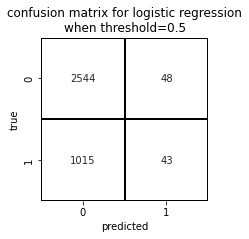



4.06% of the good stories have been correctly identified ~ recall
1.85% of the bad stories have been incorrectly identified as good ones ~ TNR




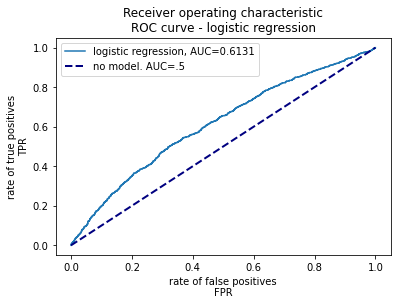

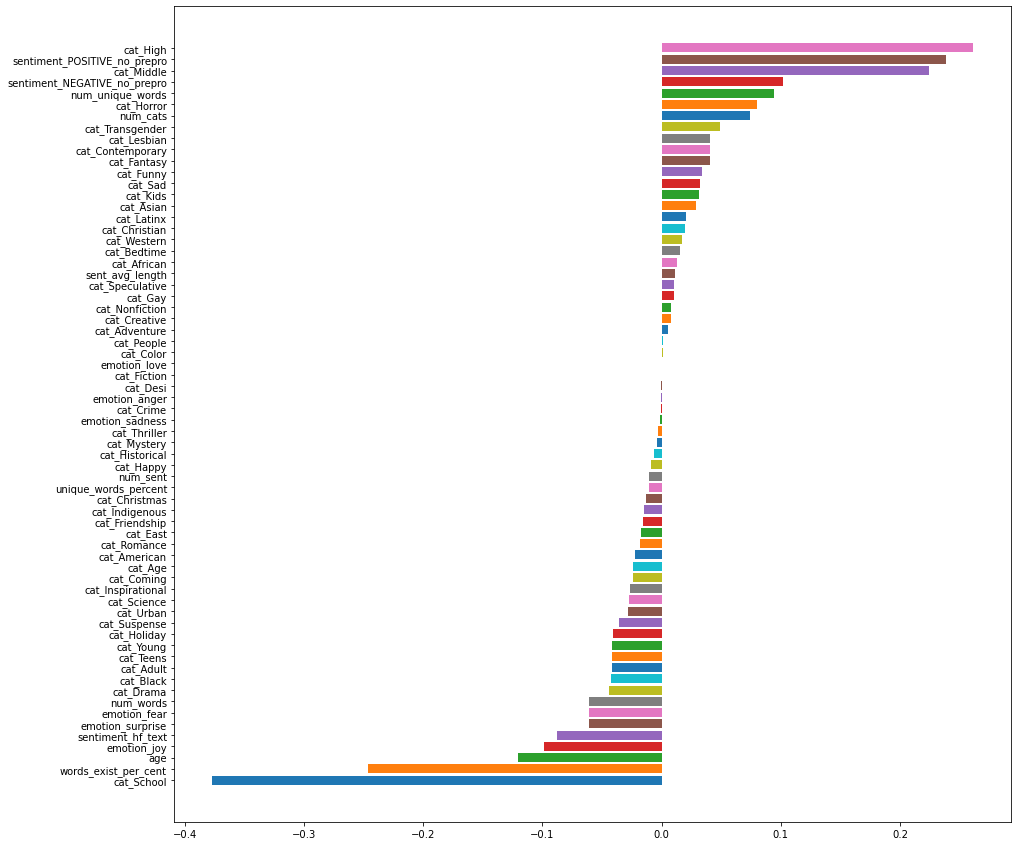

In [48]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'logistic regression')

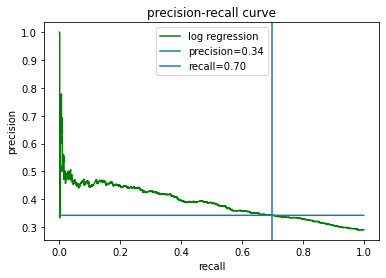



When recall is equal to 0.70, precision is equal to 0.34,            and the threshold is equal to 0.26.


In [65]:
recall_value = 0.7 # chose wanted recall value
log_probs = clf_log.predict_proba(X_test_gen)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, log_probs, 'log regression')

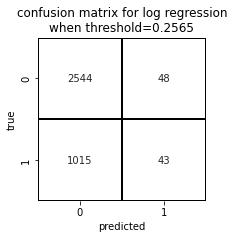



4.06% of the good stories have been correctly identified ~ recall
1.85% of the bad stories have been incorrectly identified as good ones ~ TNR


In [71]:
y_pred_log = clf_log.predict(X_test_gen)
display_conf_matr(y_test, y_pred_log, 'log regression', p_threshold)

### SVM

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.57      0.02      0.03      1058

    accuracy                           0.71      3650
   macro avg       0.64      0.51      0.43      3650
weighted avg       0.67      0.71      0.60      3650



Confusion matrix:
[[2580   12]
 [1042   16]]




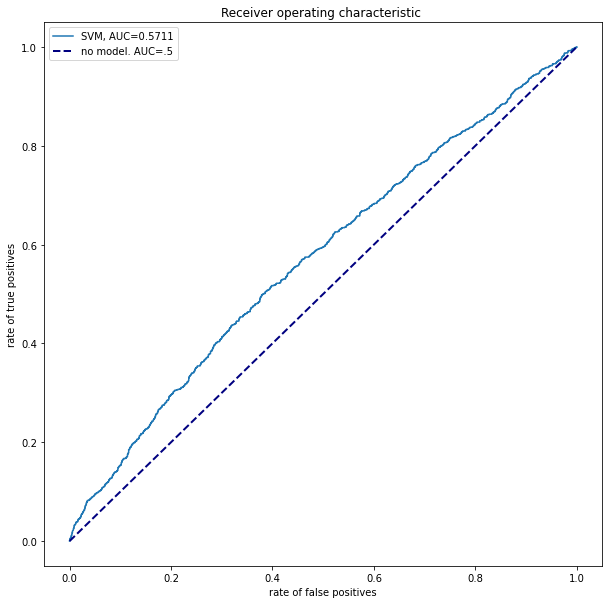



1.51% of the good stories are rightly identified.
0.46% of the bad stories are identified as good ones.


No feature importance


In [27]:
clf_svm = display_model_results(SVC(probability=True), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'SVM')

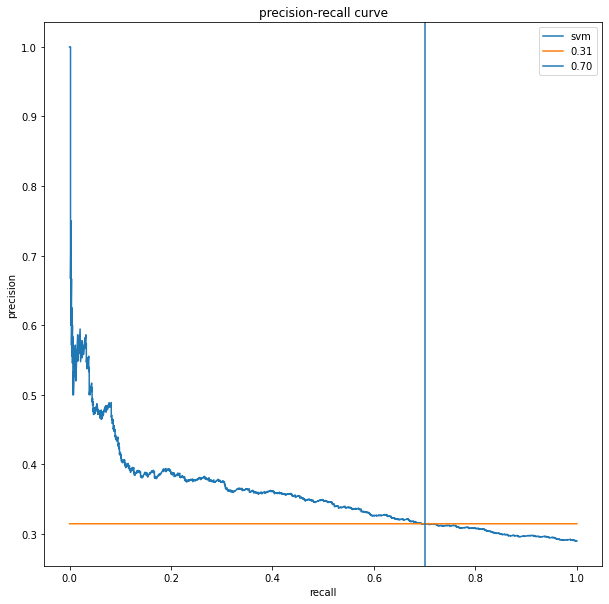



When recall is equal to 0.70, precision is equal to 0.31,and the threshold is equal to 0.27.


In [28]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_svm, 'svm')

In [29]:
conf_matrix(clf_log, p_threshold, X_test_gen, y_test)

62.76% of the good stories are rightly identified.
46.91% of the bad stories are identified as good ones.


Confusion matrix when p=0.27:
[[1376 1216]
 [ 394  664]]


### KNN 

k that minimizes the validation set error: 18


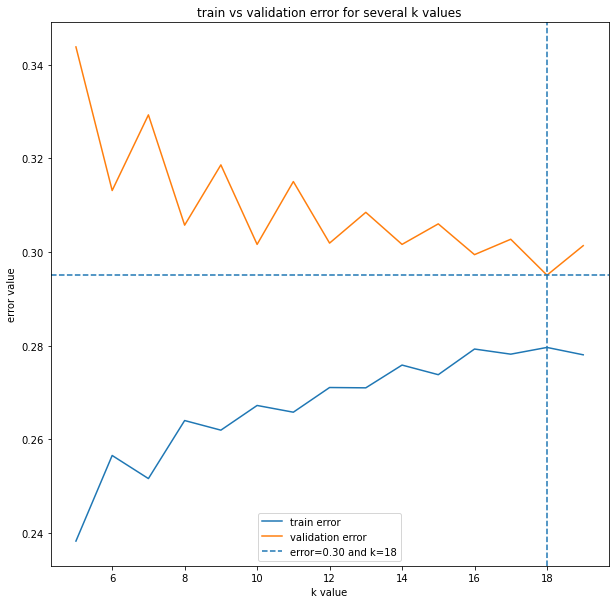

In [30]:
errors_train = []
errors_val = []
k_values = list(range(5, 20))

for k in k_values:
  neigh = KNeighborsClassifier(k)
  neigh.fit(X_train_gen, y_train)
  error_train = 1 - neigh.score(X_train_gen, y_train) 
  error_val   = 1 - neigh.score(X_test_gen, y_test) 
  errors_train.append(error_train)
  errors_val.append(error_val)

k_best = k_values[errors_val.index(min(errors_val))]
plt.figure(figsize=(10,10))
plt.plot(k_values, errors_train, label='train error')
plt.plot(k_values, errors_val, label='validation error')
plt.axhline(y = min(errors_val), linestyle = '--', label=f'error={min(errors_val):.2f} and k={k_best}')
plt.axvline(x=k_best, linestyle = '--')
plt.xlabel('k value')
plt.ylabel('error value')
plt.title('train vs validation error for several k values')
plt.legend()

print(f'k that minimizes the validation set error: {k_best}')

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.42      0.05      0.09      1058

    accuracy                           0.70      3650
   macro avg       0.57      0.51      0.46      3650
weighted avg       0.63      0.70      0.61      3650



Confusion matrix:
[[2522   70]
 [1007   51]]




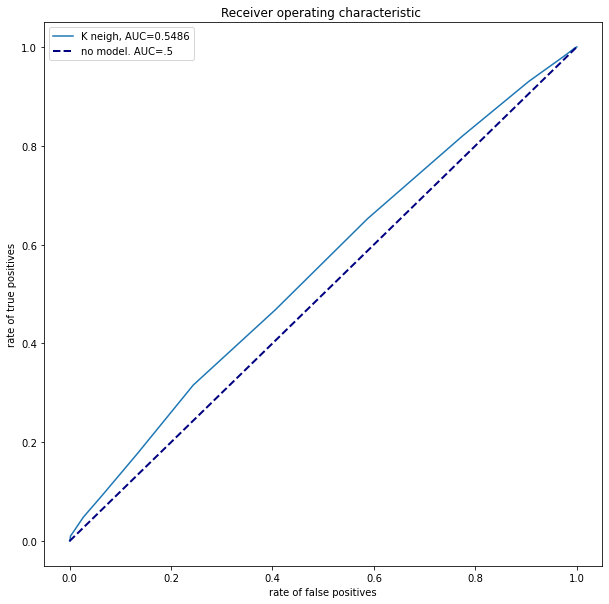



4.82% of the good stories are rightly identified.
2.70% of the bad stories are identified as good ones.


No feature importance


In [31]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'K neigh')

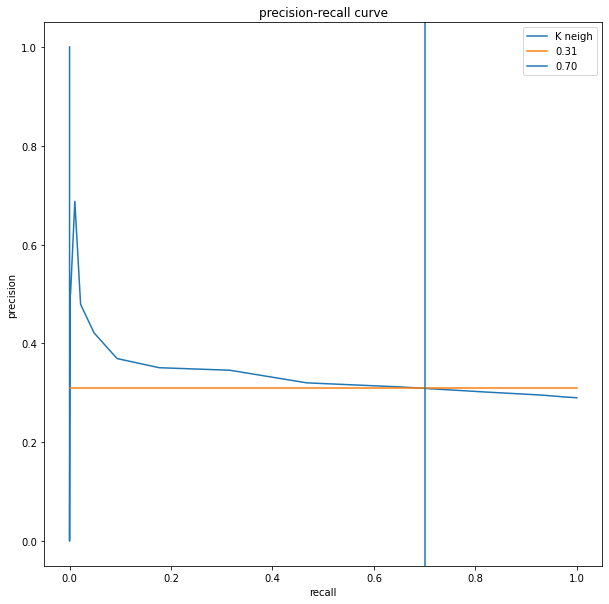



When recall is equal to 0.70, precision is equal to 0.31,and the threshold is equal to 0.26.


In [32]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_neigh, 'K neigh')

In [33]:
conf_matrix(clf_neigh, p_threshold, X_test_gen, y_test)

65.22% of the good stories are rightly identified.
58.72% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[1070 1522]
 [ 368  690]]


### Random forest

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.54      0.02      0.03      1058

    accuracy                           0.71      3650
   macro avg       0.63      0.51      0.43      3650
weighted avg       0.66      0.71      0.60      3650



Confusion matrix:
[[2576   16]
 [1039   19]]




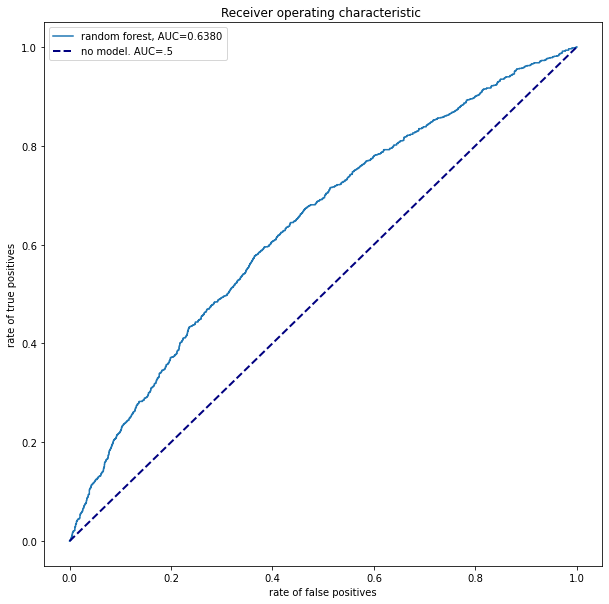



1.80% of the good stories are rightly identified.
0.62% of the bad stories are identified as good ones.


No feature importance


In [34]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=10), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'random forest')

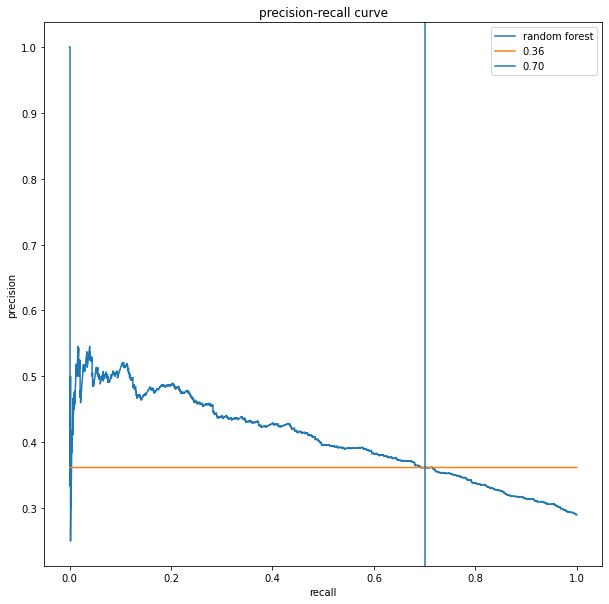



When recall is equal to 0.70, precision is equal to 0.36,and the threshold is equal to 0.26.


In [37]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_rf, 'random forest')

In [38]:
conf_matrix(clf_neigh, p_threshold, X_test_gen, y_test)

65.22% of the good stories are rightly identified.
58.72% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[1070 1522]
 [ 368  690]]


# TF/IDF only

## Preprocessing

In [39]:
max_features = 10000

In [40]:
stories_lemma = df.text_str_lem.tolist()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             max_features=max_features,
                             stop_words={'english'})

X = pd.DataFrame(vectorizer.fit_transform(stories_lemma).toarray())

In [44]:
X_train = X.iloc[train_ind]
X_test = X.iloc[test_ind]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14598, 10000), (3650, 10000), (14598,), (3650,))

## Predictions

### Log regression

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




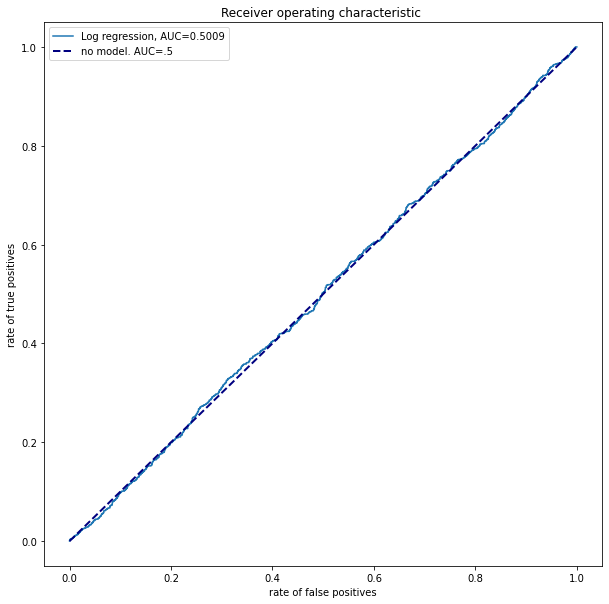



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.




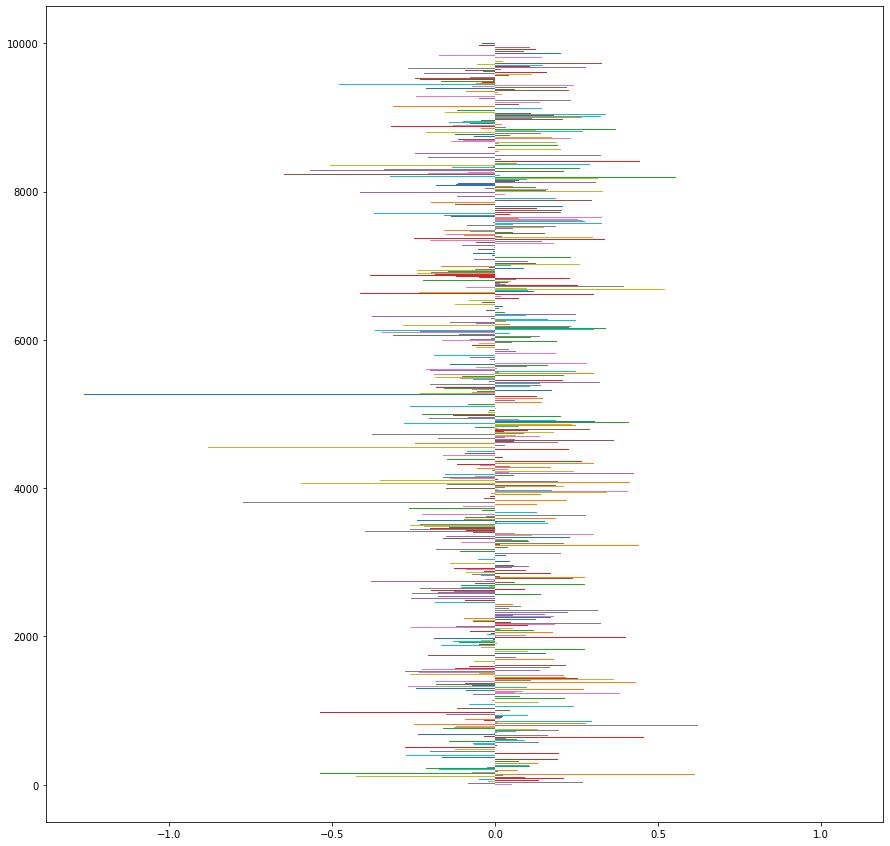

In [45]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train, X_test, y_train, y_test, 
                      'Log regression')

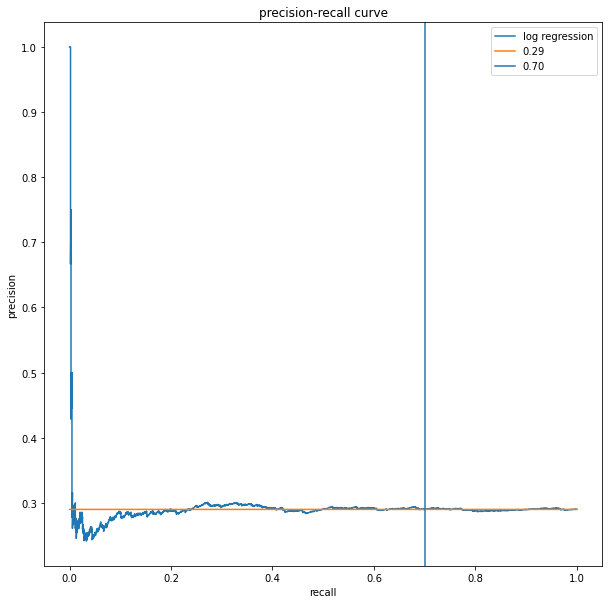



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.27.


In [46]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_log, 'log regression')

In [47]:
conf_matrix(clf_log, p_threshold, X_test, y_test)

69.94% of the good stories are rightly identified.
69.95% of the bad stories are identified as good ones.


Confusion matrix when p=0.27:
[[ 779 1813]
 [ 318  740]]


### SVM

In [48]:
# takes too much time
# clf_svm = display_model_results(SVC(probability=False, ), 
#                       X_train, X_test, y_train, y_test, 
#                       'SVM')

In [49]:
# recall_value = 0.5 # chose wanted recall value
# play_with_threshold(recall_value, y_test, clf_svm, 'svm')

### KNN

              precision    recall  f1-score   support

           0       0.71      0.99      0.82      2592
           1       0.21      0.01      0.02      1058

    accuracy                           0.70      3650
   macro avg       0.46      0.50      0.42      3650
weighted avg       0.57      0.70      0.59      3650



Confusion matrix:
[[2555   37]
 [1048   10]]




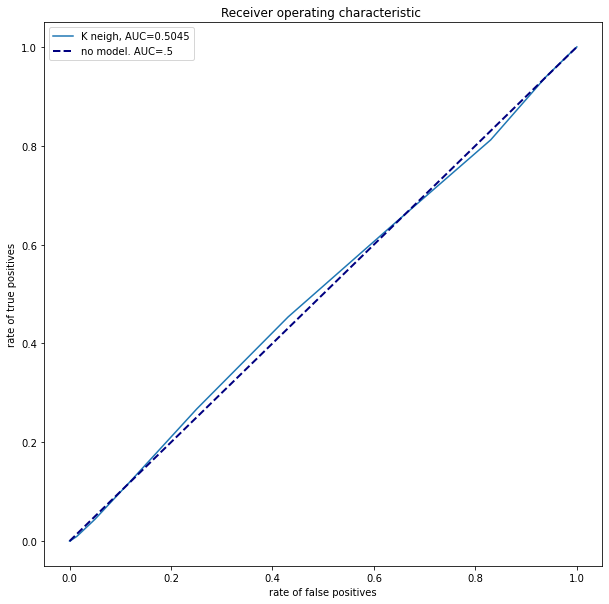



0.95% of the good stories are rightly identified.
1.43% of the bad stories are identified as good ones.


No feature importance


In [50]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train, X_test, y_train, y_test, 
                      'K neigh')

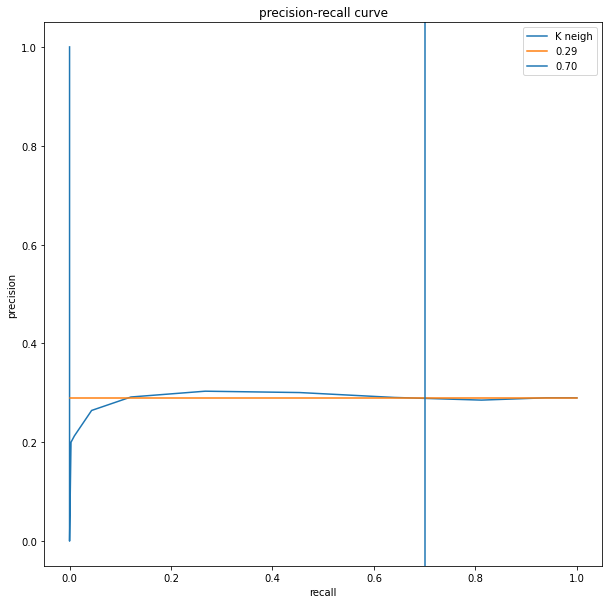



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.26.


In [51]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_neigh, 'K neigh')

In [52]:
conf_matrix(clf_neigh, p_threshold, X_test, y_test)

63.99% of the good stories are rightly identified.
63.73% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[ 940 1652]
 [ 381  677]]


### Random forest

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




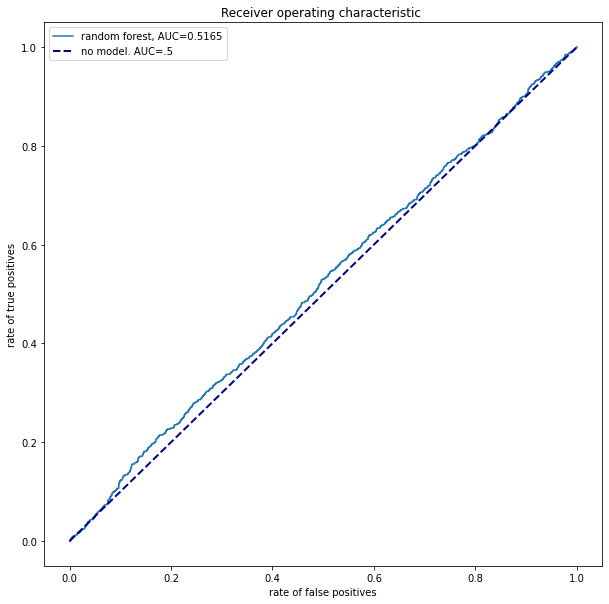



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.


No feature importance


In [53]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1), 
                      X_train, X_test, y_train, y_test, 
                      'random forest')

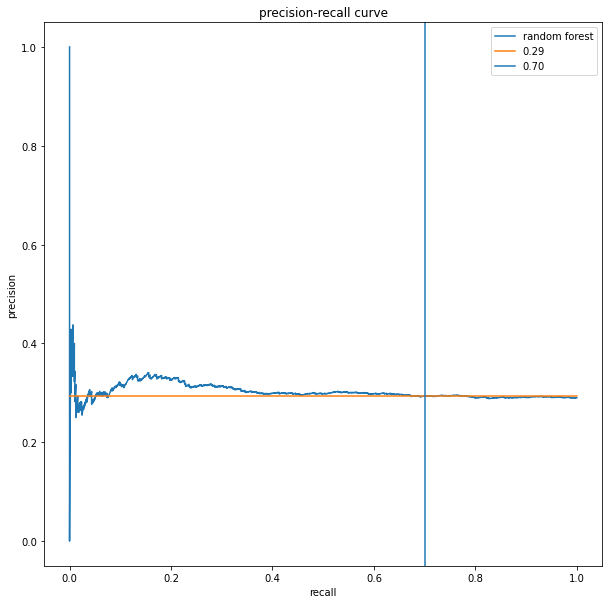



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.28.


In [54]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_rf, 'random forest')

In [55]:
conf_matrix(clf_rf, p_threshold, X_test, y_test)

70.04% of the good stories are rightly identified.
68.75% of the bad stories are identified as good ones.


Confusion matrix when p=0.28:
[[ 810 1782]
 [ 317  741]]


### Adaboost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      2592
           1       0.30      0.06      0.10      1058

    accuracy                           0.69      3650
   macro avg       0.51      0.50      0.46      3650
weighted avg       0.59      0.69      0.60      3650



Confusion matrix:
[[2448  144]
 [ 995   63]]




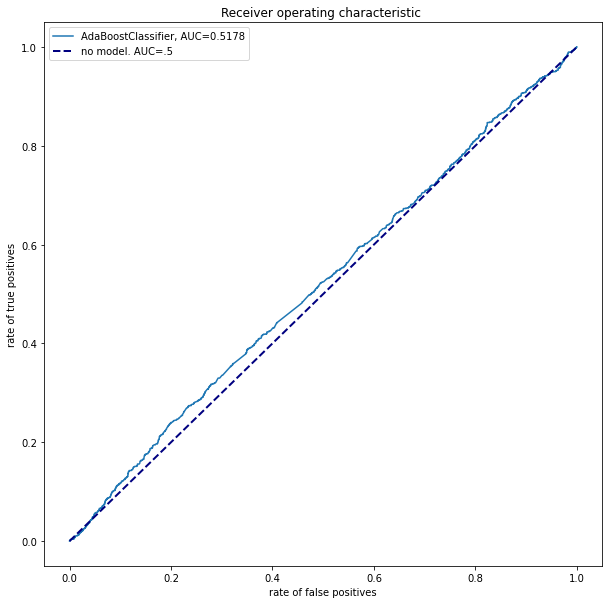



5.95% of the good stories are rightly identified.
5.56% of the bad stories are identified as good ones.


No feature importance


In [57]:
clf_ada = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train, X_test, y_train, y_test, 
                      'AdaBoostClassifier')

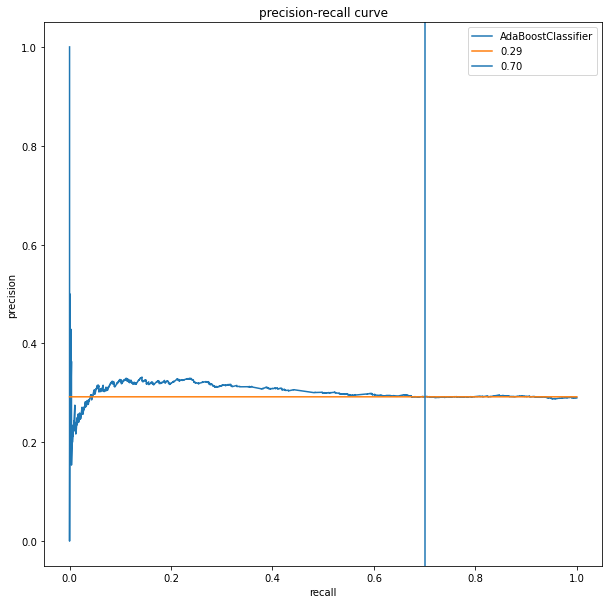



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.50.


In [65]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_ada, 'AdaBoostClassifier')

In [66]:
conf_matrix(clf_ada, p_threshold, X_test, y_test)

69.94% of the good stories are rightly identified.
69.25% of the bad stories are identified as good ones.


Confusion matrix when p=0.50:
[[ 797 1795]
 [ 318  740]]


### GradientBoostingClassifier

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      2592
           1       0.29      0.06      0.10      1058

    accuracy                           0.68      3650
   macro avg       0.50      0.50      0.46      3650
weighted avg       0.59      0.68      0.60      3650



Confusion matrix:
[[2427  165]
 [ 991   67]]




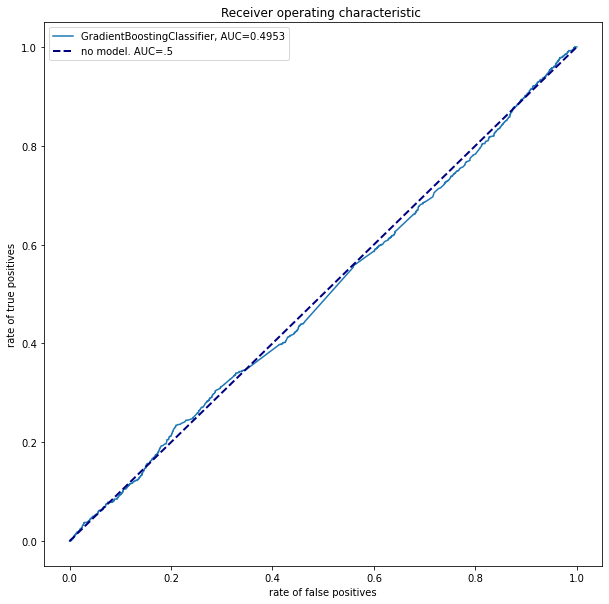



6.33% of the good stories are rightly identified.
6.37% of the bad stories are identified as good ones.


No feature importance


In [68]:
clf_gbc = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train, X_test, y_train, y_test, 
                      'GradientBoostingClassifier')

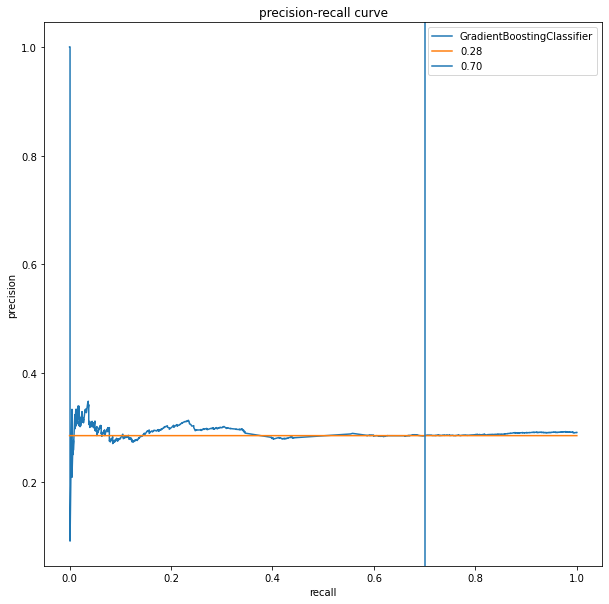



When recall is equal to 0.70, precision is equal to 0.28,and the threshold is equal to 0.22.


In [69]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_gbc, 'GradientBoostingClassifier')

In [70]:
conf_matrix(clf_gbc, p_threshold, X_test, y_test)

69.66% of the good stories are rightly identified.
71.60% of the bad stories are identified as good ones.


Confusion matrix when p=0.22:
[[ 736 1856]
 [ 321  737]]


### HistGradientBoostingClassifier

In [71]:
from sklearn.ensemble import HistGradientBoostingClassifier

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




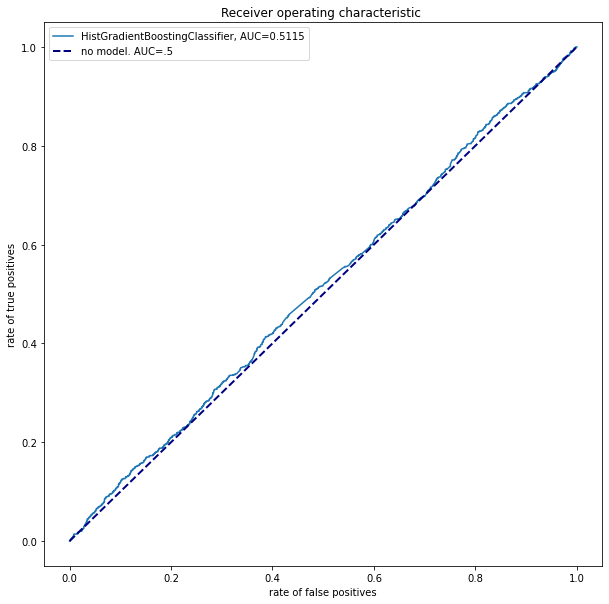



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.


No feature importance


In [72]:
clf_hist = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train, X_test, y_train, y_test, 
                      'HistGradientBoostingClassifier')

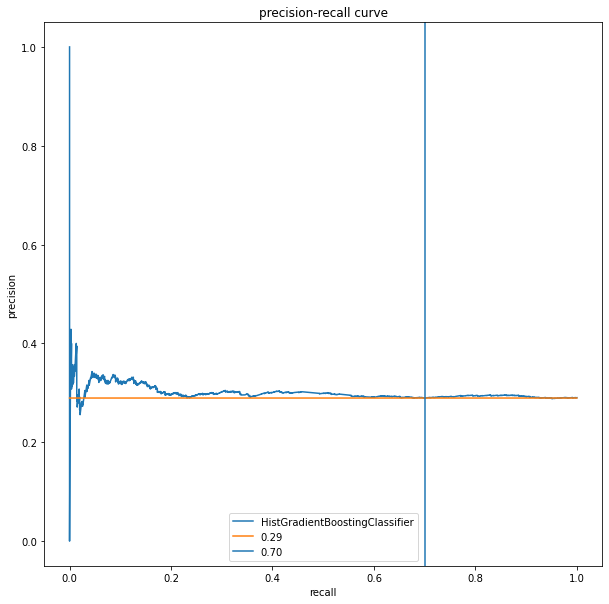



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.27.


In [73]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, clf_hist, 'HistGradientBoostingClassifier')

In [74]:
conf_matrix(clf_hist, p_threshold, X_test, y_test)

69.85% of the good stories are rightly identified.
70.06% of the bad stories are identified as good ones.


Confusion matrix when p=0.27:
[[ 776 1816]
 [ 319  739]]


### Soft vote

In [75]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('log', clf_log), 
                                    ('neigh', clf_neigh), 
                                    ('rf', clf_rf), 
                                    ('ada', clf_ada), 
                                    ('gbc', clf_gbc)], 
                        voting='soft')

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.40      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.56      0.50      0.42      3650
weighted avg       0.62      0.71      0.59      3650



Confusion matrix:
[[2589    3]
 [1056    2]]




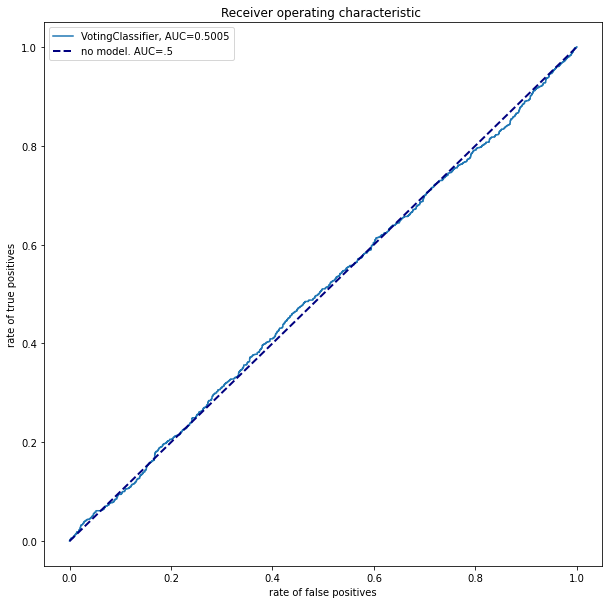



0.19% of the good stories are rightly identified.
0.12% of the bad stories are identified as good ones.


No feature importance


In [76]:
eclf = display_model_results(eclf, 
                      X_train, X_test, y_train, y_test, 
                      'VotingClassifier')

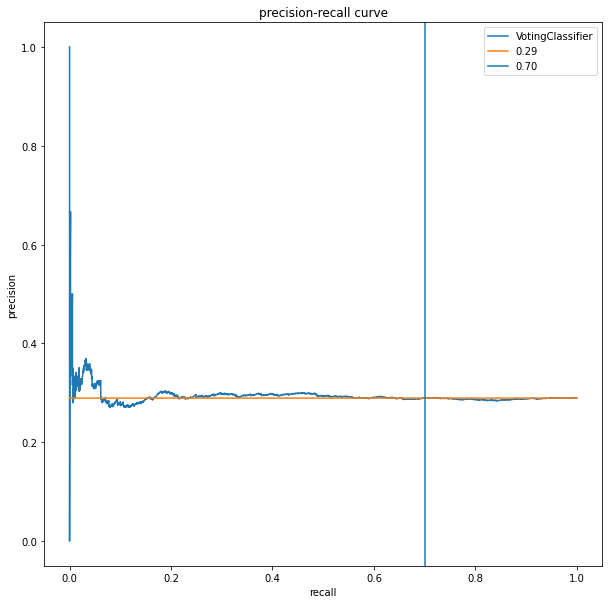



When recall is equal to 0.70, precision is equal to 0.29,and the threshold is equal to 0.31.


In [77]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test, y_test, eclf, 'VotingClassifier')

In [78]:
conf_matrix(eclf, p_threshold, X_test, y_test)

70.04% of the good stories are rightly identified.
70.14% of the bad stories are identified as good ones.


Confusion matrix when p=0.31:
[[ 774 1818]
 [ 317  741]]


# TF/IDF and general features (ensembling)

In [79]:
X_train_all = pd.concat([X_train_gen, X_train], axis=1)
X_test_all = pd.concat([X_test_gen, X_test], axis=1)

X_train_gen.shape, X_train.shape, X_train_all.shape, X_test_gen.shape, X_test.shape, X_test_all.shape

((14598, 67),
 (14598, 10000),
 (14598, 10067),
 (3650, 67),
 (3650, 10000),
 (3650, 10067))

## Predictions

### Log regression

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.97      0.82      2592
           1       0.44      0.06      0.11      1058

    accuracy                           0.71      3650
   macro avg       0.58      0.51      0.46      3650
weighted avg       0.64      0.71      0.62      3650



Confusion matrix:
[[2513   79]
 [ 995   63]]




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


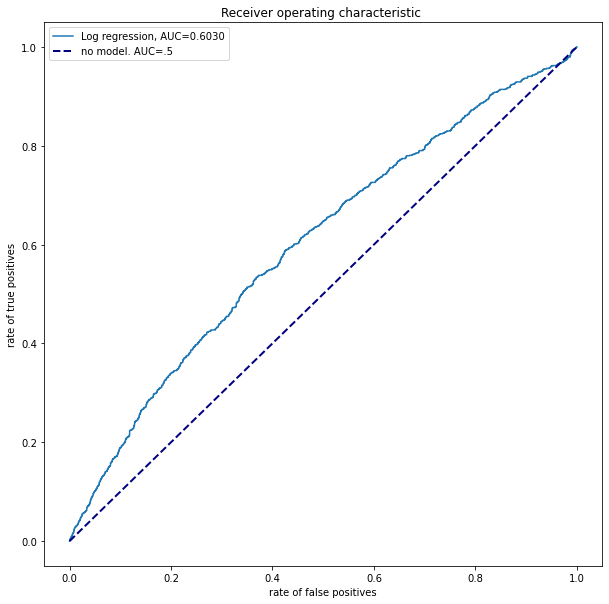



5.95% of the good stories are rightly identified.
3.05% of the bad stories are identified as good ones.




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


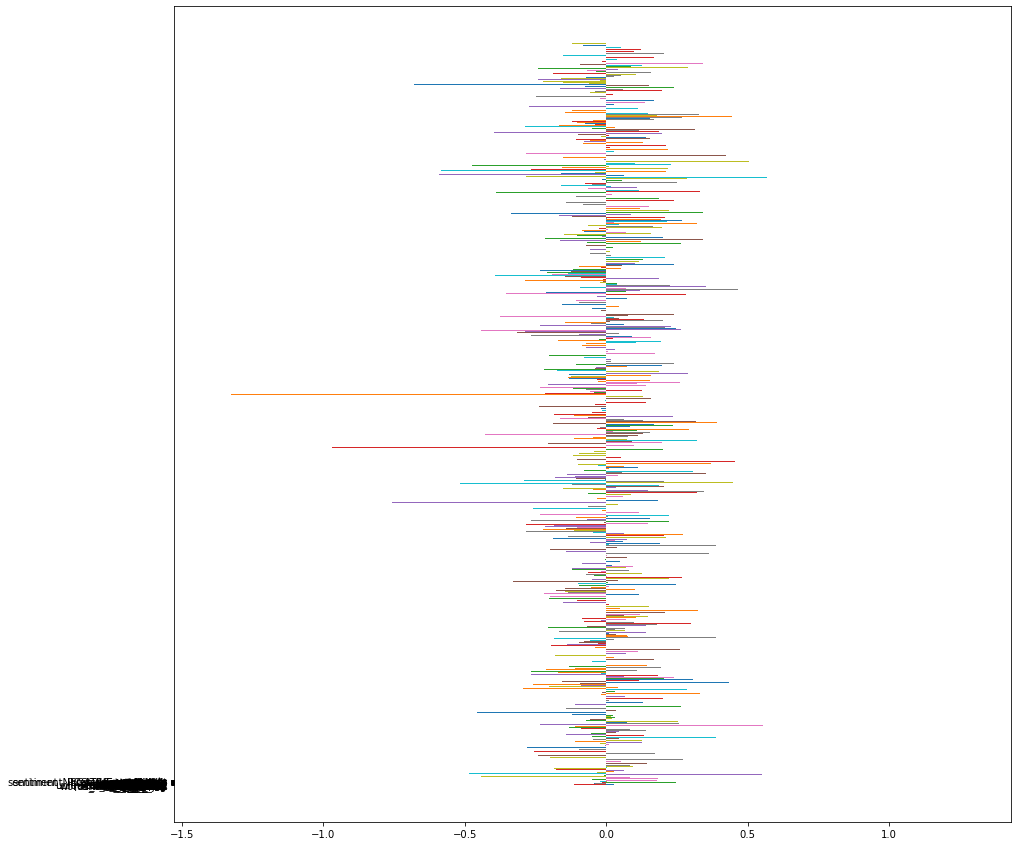

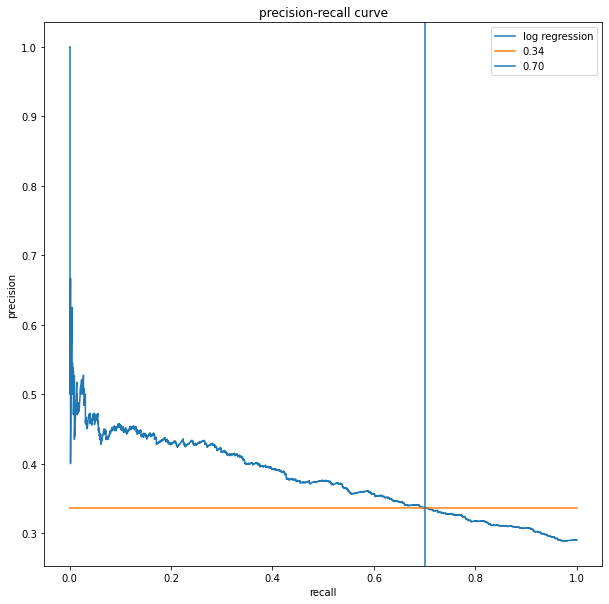



When recall is equal to 0.70, precision is equal to 0.34,and the threshold is equal to 0.25.
69.94% of the good stories are rightly identified.
56.37% of the bad stories are identified as good ones.


Confusion matrix when p=0.25:
[[1131 1461]
 [ 318  740]]


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [80]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'Log regression')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_log, 'log regression')

conf_matrix(clf_log, p_threshold, X_test_all, y_test)

### KNN

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.39      0.05      0.08      1058

    accuracy                           0.70      3650
   macro avg       0.55      0.51      0.45      3650
weighted avg       0.62      0.70      0.61      3650



Confusion matrix:
[[2518   74]
 [1010   48]]




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


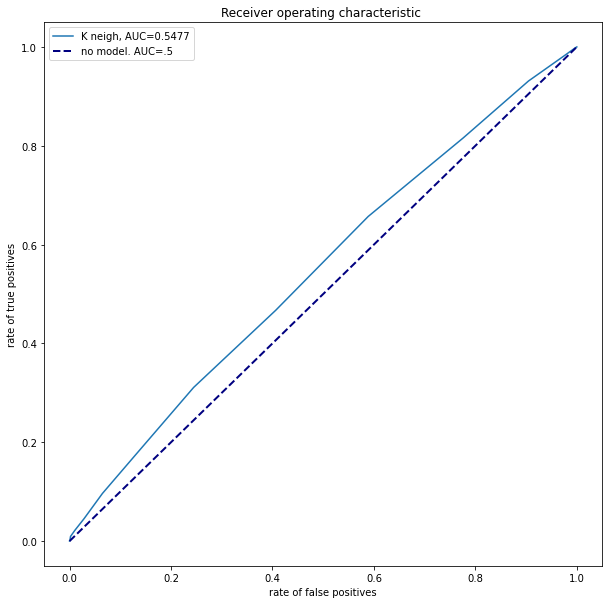



4.54% of the good stories are rightly identified.
2.85% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


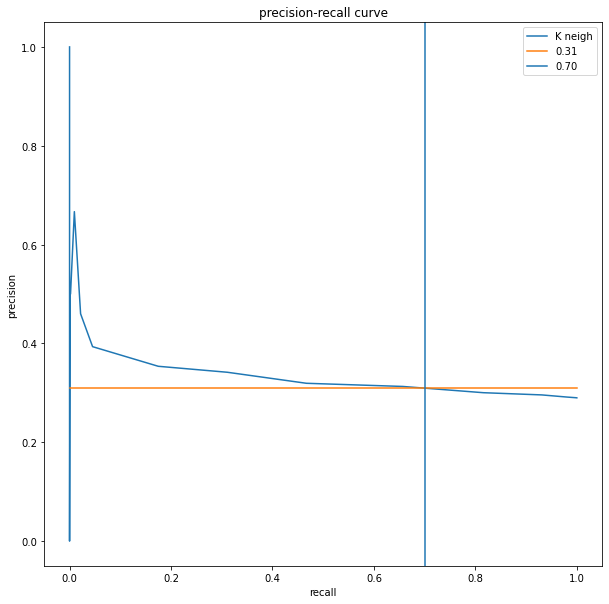



When recall is equal to 0.70, precision is equal to 0.31,and the threshold is equal to 0.26.


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


65.69% of the good stories are rightly identified.
58.87% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[1066 1526]
 [ 363  695]]


In [81]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'K neigh')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_neigh, 'K neigh')

conf_matrix(clf_neigh, p_threshold, X_test_all, y_test)

### Random forest

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




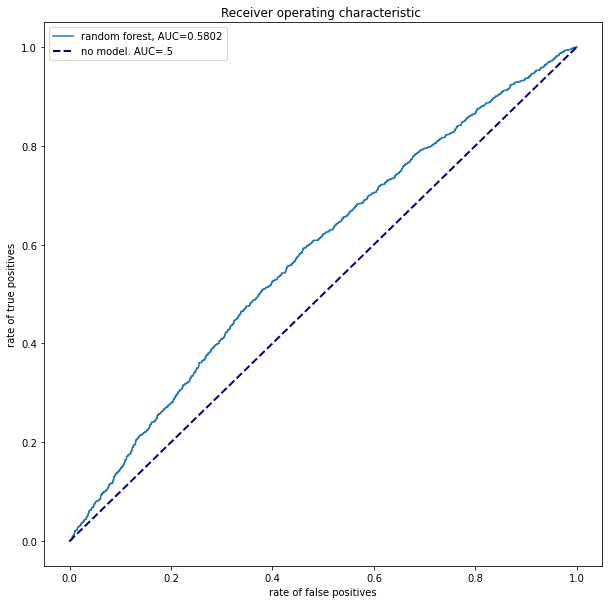



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


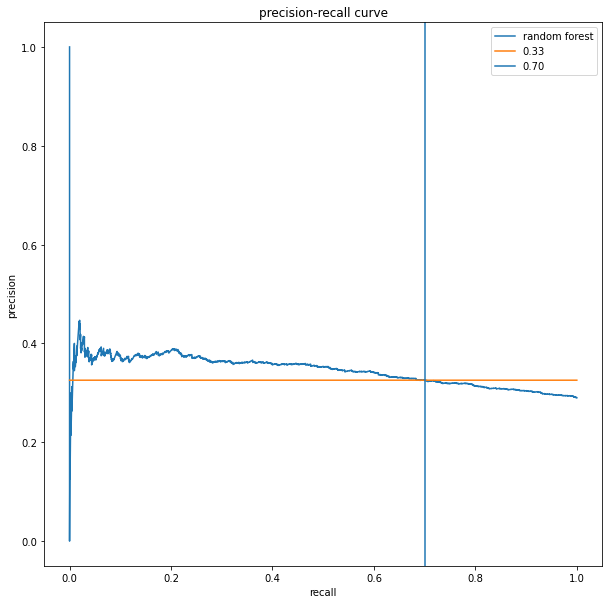



When recall is equal to 0.70, precision is equal to 0.33,and the threshold is equal to 0.28.
69.94% of the good stories are rightly identified.
59.22% of the bad stories are identified as good ones.


Confusion matrix when p=0.28:
[[1057 1535]
 [ 318  740]]


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [82]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'random forest')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_rf, 'random forest')

conf_matrix(clf_rf, p_threshold, X_test_all, y_test)

### Adaboost

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2592
           1       0.45      0.17      0.24      1058

    accuracy                           0.70      3650
   macro avg       0.59      0.54      0.53      3650
weighted avg       0.65      0.70      0.65      3650



Confusion matrix:
[[2375  217]
 [ 882  176]]




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


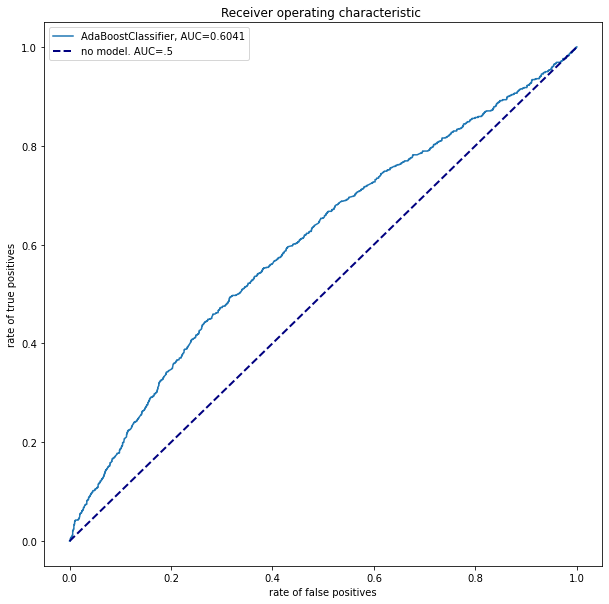



16.64% of the good stories are rightly identified.
8.37% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


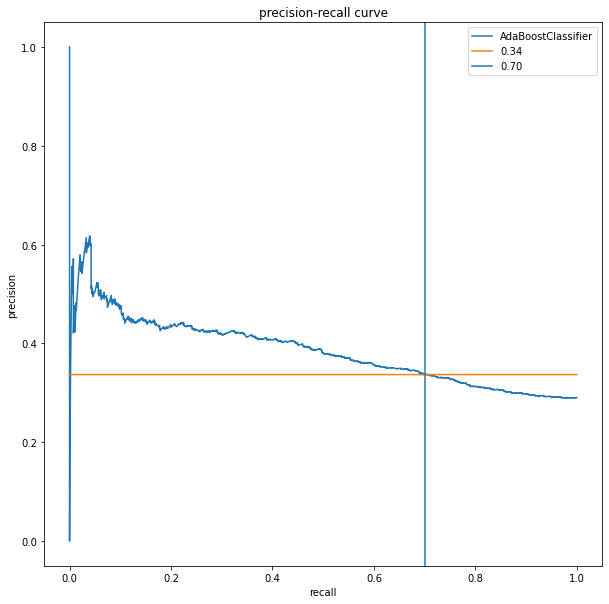



When recall is equal to 0.70, precision is equal to 0.34,and the threshold is equal to 0.50.


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


70.04% of the good stories are rightly identified.
56.21% of the bad stories are identified as good ones.


Confusion matrix when p=0.50:
[[1135 1457]
 [ 317  741]]


In [83]:
clf_ada = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'AdaBoostClassifier')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_ada, 'AdaBoostClassifier')

conf_matrix(clf_ada, p_threshold, X_test_all, y_test)

### GradientBoostingClassifier

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.92      0.81      2592
           1       0.42      0.14      0.21      1058

    accuracy                           0.69      3650
   macro avg       0.57      0.53      0.51      3650
weighted avg       0.64      0.69      0.64      3650



Confusion matrix:
[[2383  209]
 [ 908  150]]




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


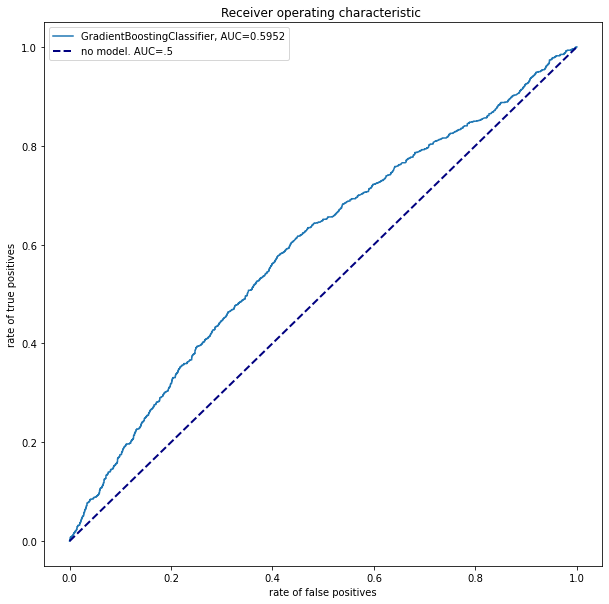



14.18% of the good stories are rightly identified.
8.06% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


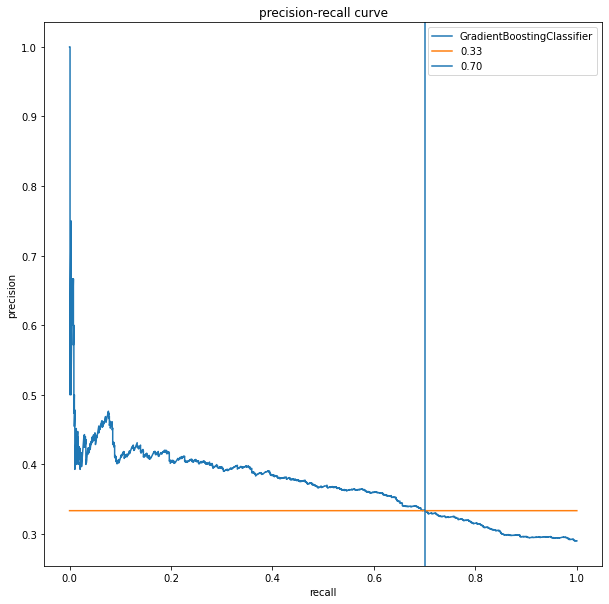



When recall is equal to 0.70, precision is equal to 0.33,and the threshold is equal to 0.22.


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


70.04% of the good stories are rightly identified.
57.18% of the bad stories are identified as good ones.


Confusion matrix when p=0.22:
[[1110 1482]
 [ 317  741]]


In [84]:
clf_gbc = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'GradientBoostingClassifier')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_gbc, 'GradientBoostingClassifier')

conf_matrix(clf_gbc, p_threshold, X_test_all, y_test)

### HistGradientBoostingClassifier

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.97      0.83      2592
           1       0.51      0.07      0.12      1058

    accuracy                           0.71      3650
   macro avg       0.61      0.52      0.47      3650
weighted avg       0.66      0.71      0.62      3650



Confusion matrix:
[[2523   69]
 [ 986   72]]




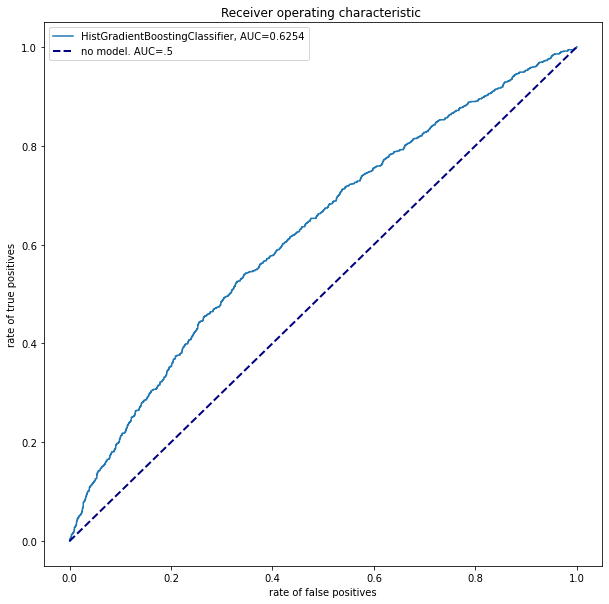



6.81% of the good stories are rightly identified.
2.66% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


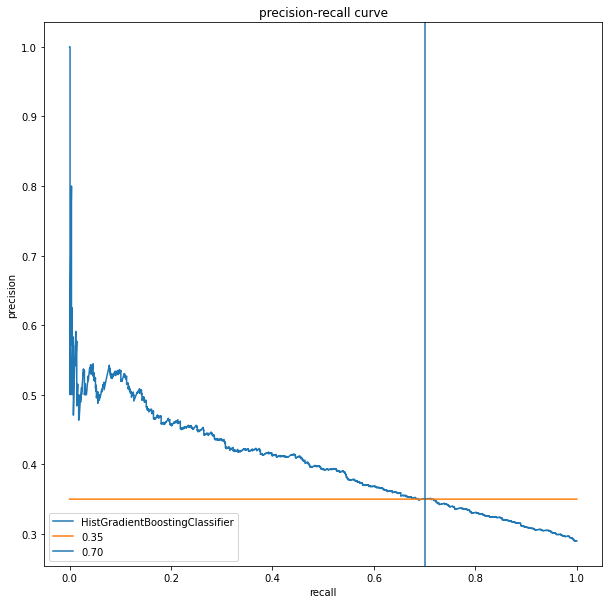



When recall is equal to 0.70, precision is equal to 0.35,and the threshold is equal to 0.25.
69.94% of the good stories are rightly identified.
53.09% of the bad stories are identified as good ones.


Confusion matrix when p=0.25:
[[1216 1376]
 [ 318  740]]


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [85]:
clf_hist = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'HistGradientBoostingClassifier')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_hist, 'HistGradientBoostingClassifier')

conf_matrix(clf_hist, p_threshold, X_test_all, y_test)

### Soft vote

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.71      0.02      0.03      1058

    accuracy                           0.71      3650
   macro avg       0.71      0.51      0.43      3650
weighted avg       0.71      0.71      0.60      3650



Confusion matrix:
[[2585    7]
 [1041   17]]




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib

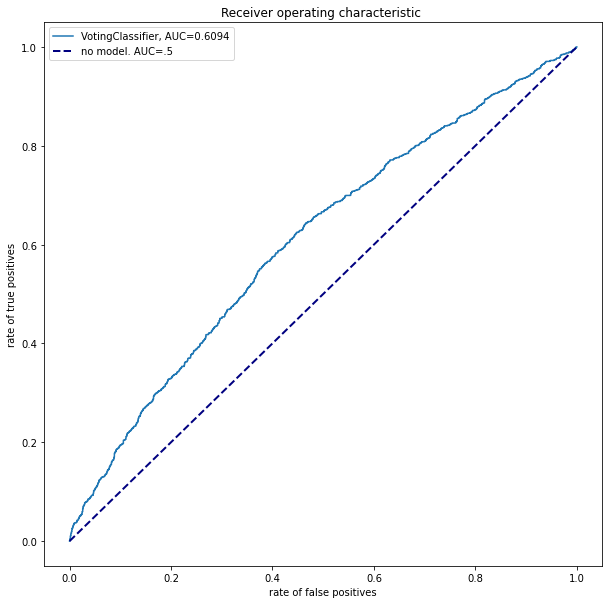



1.61% of the good stories are rightly identified.
0.27% of the bad stories are identified as good ones.


No feature importance


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib

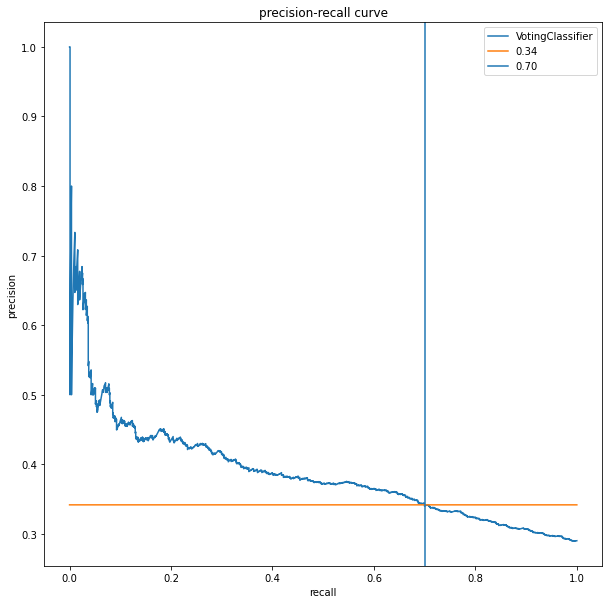



When recall is equal to 0.70, precision is equal to 0.34,and the threshold is equal to 0.31.


C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib

69.94% of the good stories are rightly identified.
55.02% of the bad stories are identified as good ones.


Confusion matrix when p=0.31:
[[1166 1426]
 [ 318  740]]


In [86]:
eclf = VotingClassifier(estimators=[('log', clf_log), 
                                    ('neigh', clf_neigh), 
                                    ('rf', clf_rf), 
                                    ('ada', clf_ada), 
                                    ('gbc', clf_gbc)], 
                        voting='soft')

eclf = display_model_results(eclf, 
                      X_train_all, X_test_all, y_train, y_test, 
                      'VotingClassifier')

recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, eclf, 'VotingClassifier')

conf_matrix(eclf, p_threshold, X_test_all, y_test)